## Loan Data from Prosper Exploration


## Preliminary Wrangling

This document explores a dataset containing 113,937 loans with 81 variables on each loan, including loan amount, borrower rate (or interest rate), current loan  status, borrower income, borrower employment status, borrower credit  history, and the latest payment information.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

In [2]:
# load in the dataset into a pandas dataframe, print statistics
loan = pd.read_csv('prosperLoanData.csv')

In [3]:
# high-level overview of data shape and composition
print(loan.shape)
print(loan.dtypes)
print(loan.head(10))

(113937, 81)
ListingKey                      object
ListingNumber                    int64
ListingCreationDate             object
CreditGrade                     object
Term                             int64
                                ...   
PercentFunded                  float64
Recommendations                  int64
InvestmentFromFriendsCount       int64
InvestmentFromFriendsAmount    float64
Investors                        int64
Length: 81, dtype: object
                ListingKey  ListingNumber            ListingCreationDate  \
0  1021339766868145413AB3B         193129  2007-08-26 19:09:29.263000000   
1  10273602499503308B223C1        1209647  2014-02-27 08:28:07.900000000   
2  0EE9337825851032864889A          81716  2007-01-05 15:00:47.090000000   
3  0EF5356002482715299901A         658116  2012-10-22 11:02:35.010000000   
4  0F023589499656230C5E3E2         909464  2013-09-14 18:38:39.097000000   
5  0F05359734824199381F61D        1074836  2013-12-14 08:26:37.093000000   


In [4]:
# change the name of all columns to lowercase and view info of data
loan.columns = loan.columns.str.lower()
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113937 entries, 0 to 113936
Data columns (total 81 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   listingkey                           113937 non-null  object 
 1   listingnumber                        113937 non-null  int64  
 2   listingcreationdate                  113937 non-null  object 
 3   creditgrade                          28953 non-null   object 
 4   term                                 113937 non-null  int64  
 5   loanstatus                           113937 non-null  object 
 6   closeddate                           55089 non-null   object 
 7   borrowerapr                          113912 non-null  float64
 8   borrowerrate                         113937 non-null  float64
 9   lenderyield                          113937 non-null  float64
 10  estimatedeffectiveyield              84853 non-null   float64
 11  estimatedloss

In [5]:
# Subset the dataframe by selecting features of interest
cols = ['prosperrating (alpha)', 'loanoriginalamount', 'borrowerapr', 'statedmonthlyincome', 'incomerange', 'term', 
        'employmentstatus']
loan_sub = loan[cols]
# data wrangling, remove loans with missing borrower APR information
loan_sub = loan_sub[~loan_sub.borrowerapr.isna()]


In [6]:
# Get percent of borrowers whose stated monthly income greater than 30k
(loan_sub.statedmonthlyincome>30000).sum()/float(loan_sub.shape[0])

0.0028706369829341947

Less than 0.3% borrowers have stated monthly income greater than 30k, these can be seemed as outlier for the following analysis, so it is better to remove borrower records with income greater than 30k.

In [7]:
# data wrangling, remove loans with stated monthly income greater than 30k, which are outliers
loan_sub = loan_sub[loan_sub.statedmonthlyincome<=30000]

In [8]:
# Convert Employment status, income range and prosper rating (alpha) into ordered categorical types
ordinal_var_dict = {'employmentstatus':['Employed','Self-employed','Full-time','Part-time','Retired','Other','Not employed', 'Not available'], 'incomerange': ["$0", "$1-24,999", "$25,000-49,999","$50,000-74,999", "$75,000-99,999", "$100,000+"], 'prosperrating (alpha)': ["HR", "E", "D","C", "B", "A", "AA"]}
for var in ordinal_var_dict:
    ordered_var = pd.api.types.CategoricalDtype(ordered = True, categories = ordinal_var_dict[var])
    loan_sub[var] = loan_sub[var].astype(ordered_var)


In [9]:
loan_sub.employmentstatus.value_counts()

Employed         67135
Full-time        26297
Self-employed     6076
Not available     5334
Other             3805
Part-time         1088
Not employed       835
Retired            794
Name: employmentstatus, dtype: int64

In [10]:
loan_sub['prosperrating (alpha)'].value_counts()

C     18291
B     15514
A     14492
D     14254
E      9785
HR     6918
AA     5350
Name: prosperrating (alpha), dtype: int64

In [11]:
loan_sub.incomerange.value_counts()

$25,000-49,999    32192
$50,000-74,999    31049
$100,000+         17035
$75,000-99,999    16915
$1-24,999          7274
$0                  621
Name: incomerange, dtype: int64

In [12]:
loan_sub.term.value_counts()

36    87497
60    24484
12     1604
Name: term, dtype: int64

In [13]:
loan_sub.statedmonthlyincome.describe()

count    113585.000000
mean       5452.015632
std        3507.054457
min           0.000000
25%        3195.166667
50%        4666.666667
75%        6750.000000
max       30000.000000
Name: statedmonthlyincome, dtype: float64

In [14]:
loan_sub.borrowerapr.describe()

count    113585.000000
mean          0.218913
std           0.080360
min           0.006530
25%           0.156290
50%           0.209840
75%           0.283860
max           0.512290
Name: borrowerapr, dtype: float64

In [15]:
loan_sub.loanoriginalamount.describe()

count    113585.000000
mean       8317.818576
std        6224.982311
min        1000.000000
25%        4000.000000
50%        6409.000000
75%       12000.000000
max       35000.000000
Name: loanoriginalamount, dtype: float64

### What is the structure of your dataset?

There are 113,937 observations in the dataset with 81 variables. Most variables are numeric in nature, some are objects. Variables are about loan information and borrower information.


### What is/are the main feature(s) of interest in your dataset?

I'm most interested in figuring out what affects the Borrower's Annual Percentage Rate (APR) for the loan? And are there differences between loans depending on how large the original loan amount was?

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

I expect that borrower information such as LoanOriginalAmount, EmploymentStatus , ProsperRating (alpha), IncomeRange and  Term will have the strongest effect on the borrower’s APR. 

## Univariate Exploration

I'll start by looking at the distribution of the main variable of interest: the borrower APR.

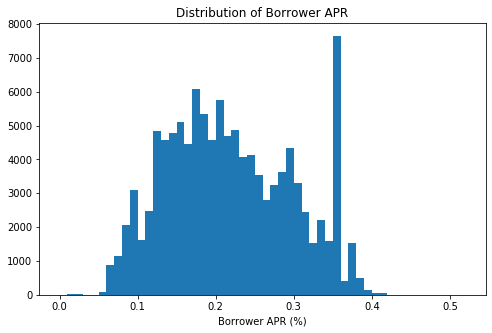

In [16]:
# plotting borrower APR on a standard scale
binsize = 0.01
bins = np.arange(0, loan_sub['borrowerapr'].max()+binsize, binsize)
plt.figure(figsize=[8, 5])
plt.hist(data = loan_sub, x = 'borrowerapr', bins = bins)
plt.xlabel('Borrower APR (%)')
plt.title('Distribution of Borrower APR');


Borrower APR is the Borrower's Annual Percentage Rate (APR) for the loan.
The distribution of APR looks multimodal, with a lot of borrowers on the borrower APR from 0.1-0.3, and few on the high borrower APR end (over 0.4). A small peak centered at 0.1, a large peak centered at 0.2. There is also a small peak centered 0.3. Additionally, there is a very shape peak between 0.35 and 0.36.

Next up, the first predictor variable of interest: Loan Original Amount.

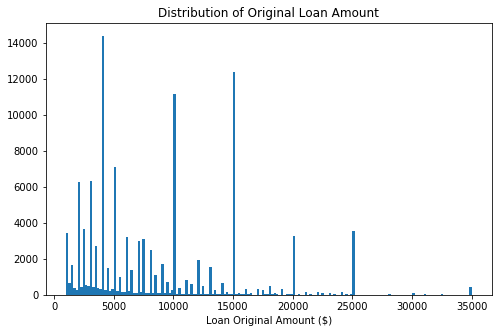

In [17]:
# loan original amount with a standard-scaled plot
binsize = 200
bins = np.arange(1000, loan_sub['loanoriginalamount'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = loan_sub, x = 'loanoriginalamount', bins = bins)
plt.xlabel('Loan Original Amount ($)')
plt.title('Distribution of Original Loan Amount');

Loan Original Amount is the origination amount of the loan.
The most popular Original Loan Amount are below 26k, especially there are some Original Loan Amounts that many borrowers chose such as below 5k, 10k, 15k, 20k, 25k. There are not too much original loan amounts over 26k.

I'll now move on to the three other variables in the dataset: income range and employment status and prosper rating (alpha).

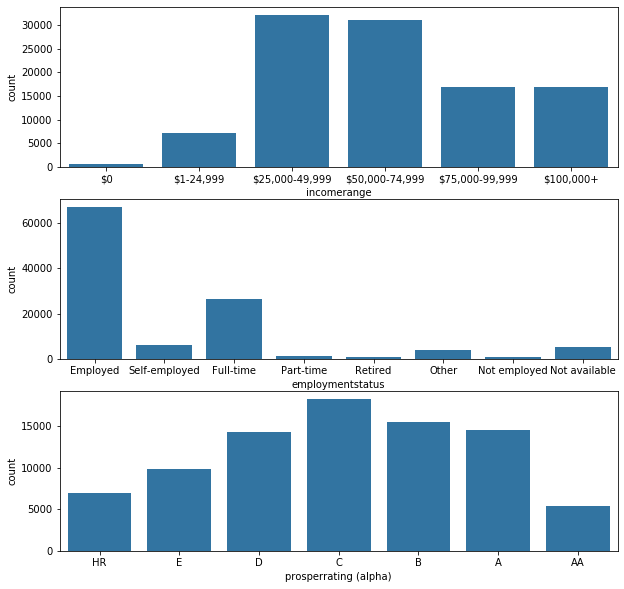

In [18]:
# let's plot three together to get an idea of each ordinal variable's distribution.

fig, ax = plt.subplots(nrows=3, figsize = [10,10])

default_color = sb.color_palette()[0]
sb.countplot(data = loan_sub, x = 'incomerange', color = default_color, ax = ax[0])
sb.countplot(data = loan_sub, x = 'employmentstatus', color = default_color, ax = ax[1])
sb.countplot(data = loan_sub, x = 'prosperrating (alpha)', color = default_color, ax = ax[2])
plt.show();

Income range is the income range of the borrower at the time the listing was created. 
The income range of the borrowers in the dataset is generally in range \\$25,000-49,999  and  \\$50,000-74,999 , with most of them are employed and full-time. The most popular prosper rating (alpha) of borrowers is C, there is little the number of borrowers who has the prosper rating (alpha) is AA.

I'll now look at the other features in the data to see how their Term are?

Text(0.5, 1.0, 'Distribution of Term (months)')

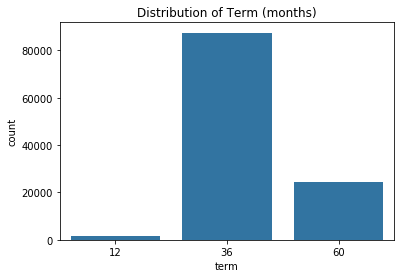

In [19]:
default_color = sb.color_palette()[0]
sb.countplot(data = loan_sub, x = 'term', color = default_color)
plt.title('Distribution of Term (months)')

Term is the length of the loan expressed in months.
There are three kinds of term and the most popular term is 36 months, the least term is 12 months.


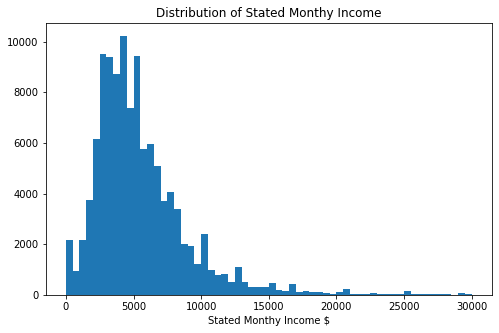

In [20]:
# plotting Stated Monthy Income on a standard scale
binsize = 500
bins = np.arange(0, loan_sub['statedmonthlyincome'].max()+binsize, binsize)
plt.figure(figsize=[8, 5])
plt.hist(data = loan_sub, x = 'statedmonthlyincome', bins = bins)
plt.xlabel('Stated Monthy Income $')
plt.title('Distribution of Stated Monthy Income');

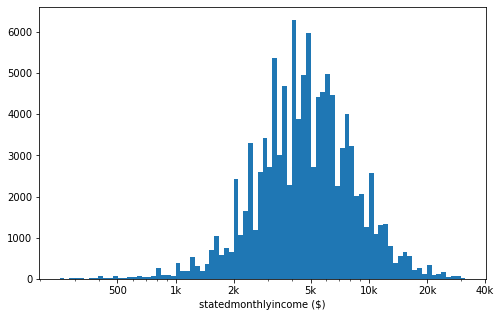

In [21]:
# there's a long tail in the distribution, so let's put it on a log scale instead
log_binsize = 0.025
bins = 10 ** np.arange(2.4, np.log10(loan_sub['statedmonthlyincome'].max())+log_binsize, log_binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = loan_sub, x = 'statedmonthlyincome', bins = bins)
plt.xscale('log')
plt.xticks([500, 1e3, 2e3, 5e3, 1e4, 2e4, 4e4], [500, '1k', '2k', '5k', '10k', '20k', '40k'])
plt.xlabel('statedmonthlyincome ($)')
plt.show()

Stated Monthly Income has a long-tailed distribution, with a lot of borrowers have the low stated monthly income end, and few on the high stated monthly income end.The distribution of stated monthly income is severely right screwed, with most of stated monthly income less than 30k. When plotted on a log-scale, the Stated Monthly Income distribution looks with the peak between \\$4,000-\\$6,000.


## Bivariate Exploration

To start off with, I want to look at the pairwise correlations present between features in the data.


In [22]:
numeric_vars = ['loanoriginalamount', 'borrowerapr', 'statedmonthlyincome']
categoric_vars = ['prosperrating (alpha)', 'term', 'employmentstatus']

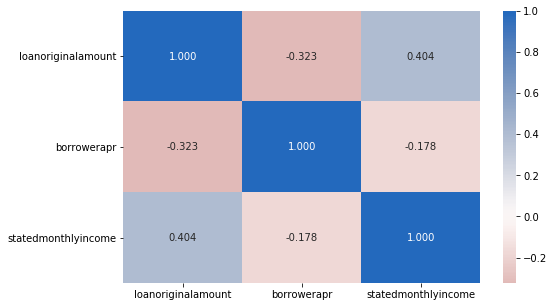

In [23]:
# correlation plot
plt.figure(figsize = [8, 5])
sb.heatmap(loan_sub[numeric_vars].corr(), annot = True, fmt = '.3f',
           cmap = 'vlag_r', center = 0)
plt.show()

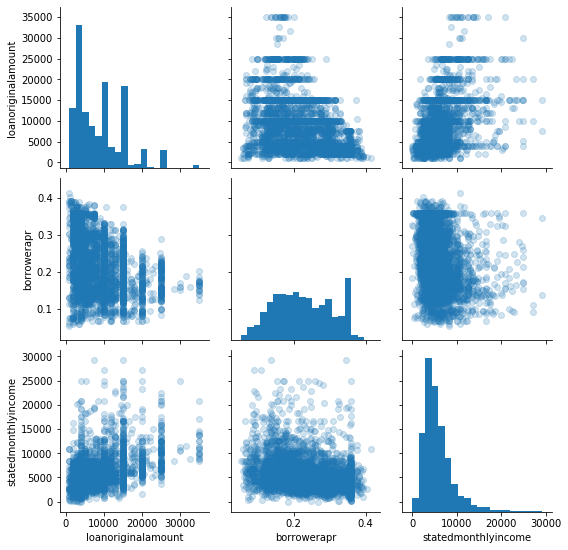

In [24]:
# plot matrix: sample 5000 loans so that plots are clearer and render faster
loan_sub_samp = loan_sub.sample(5000)
g = sb.PairGrid(data = loan_sub_samp.dropna(), vars = numeric_vars)
g = g.map_diag(plt.hist, bins=20)
g.map_offdiag(plt.scatter, alpha=0.2);

The correlation coefficient of loan amount and stated monthly income is 0.404, therefore the loan original amount is positively correlated with the stated monthly income.It makes sense since borrowers with more monthly income could loan more money.
The correlation coefficient of borrower APR and loan original amount is -0.323, the scatter plot also shows that these two variables are negatively correlated, which agrees with our hypothesis, that is the more the loan amount, the lower the APR.

Let's move on to looking at how borrower APR, stated monthly income and loan original amount correlate with the categorical variables.

C:\Users\thuyl\anaconda3\lib\site-packages\seaborn\axisgrid.py:1264: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(UserWarning(msg))


<Figure size 720x720 with 0 Axes>

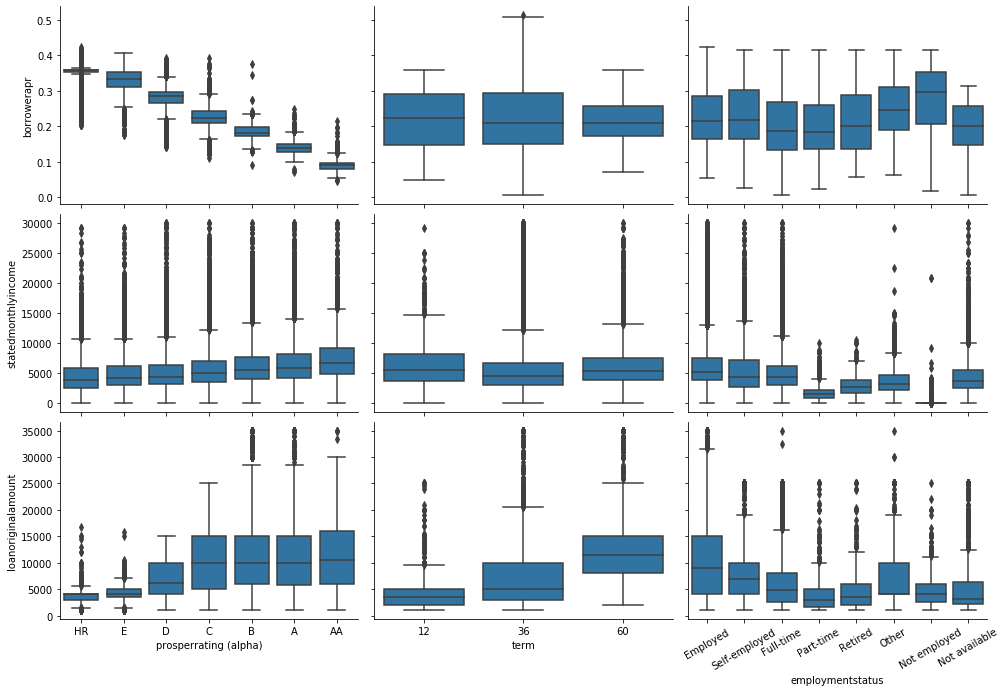

In [25]:
# plot matrix of numeric features against categorical features.

def boxgrid(x, y, **kwargs):
    """ Quick hack for creating box plots with seaborn's PairGrid. """
    default_color = sb.color_palette()[0]
    sb.boxplot(x, y, color = default_color)

plt.figure(figsize = [10, 10])
g = sb.PairGrid(data = loan_sub, y_vars = ['borrowerapr', 'statedmonthlyincome', 'loanoriginalamount'], 
                x_vars = categoric_vars, size = 3, aspect = 1.5)
g.map(boxgrid);
plt.xticks(rotation=30);

We see that the loan original amount increases with the increase of loan term. The borrower APR decreases with the better prosper rating (alpha). Borrowers with the best Prosper ratings have the lowest APR. It means that the Prosper rating has a strong effect on borrower APR. Borrowers with better rating also have larger stated monthly income and loan original amount. Employed, self-employed and full time borrowers have more stated monthly income and loan original amount than part-time, retired and not employed borrowers.

Finally, let's look at relationships between the three categorical features.

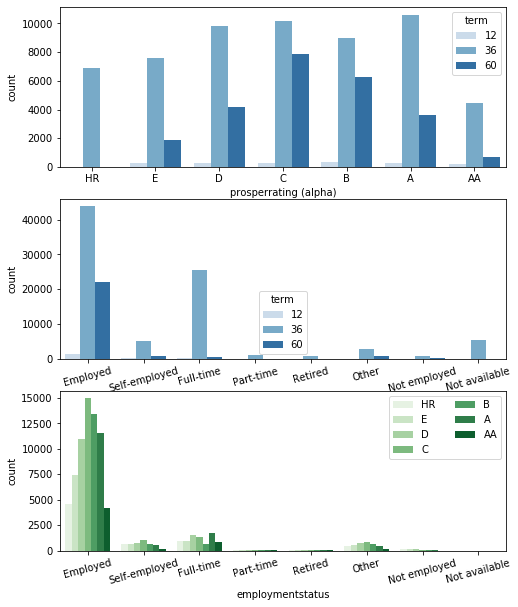

In [26]:
plt.figure(figsize = [8, 10])

# subplot 1: Prosper rating vs term
plt.subplot(3, 1, 1)
sb.countplot(data = loan_sub, x = 'prosperrating (alpha)', hue = 'term', palette = 'Blues')

# subplot 2: employment status vs. term
ax = plt.subplot(3, 1, 2)
sb.countplot(data = loan_sub, x = 'employmentstatus', hue = 'term', palette = 'Blues')
plt.xticks(rotation=15)

# subplot 3: Prosper rating vs. employment status, use different color palette
ax = plt.subplot(3, 1, 3)
sb.countplot(data = loan_sub, x = 'employmentstatus', hue = 'prosperrating (alpha)', palette = 'Greens')
ax.legend(loc = 1, ncol = 2); # re-arrange legend to remove overlapping
plt.xticks(rotation=15);

we can see that most of borrowers are employed and full-time and their borrow term is more at 36 months, their proper rating (alpha) is more on C and B. There is an interaction between term and Prosper rating. Proportionally, there are more 60 months loans on B and C ratings. There is only 36 months loans for HR rating borrowers.

With the preliminary look at bivariate relationships out of the way, I want to see how borrower APR and loan original amount are related to one another for all of the data.

### Borrower APR vs. Loan Amount

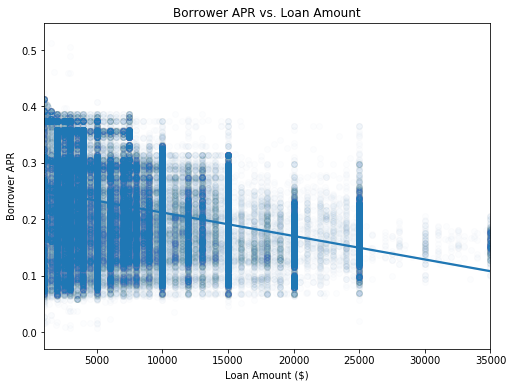

In [27]:
plt.figure(figsize = [8, 6])
sb.regplot(data = loan_sub, x = 'loanoriginalamount', y = 'borrowerapr', scatter_kws={'alpha':0.01});
plt.xlabel('Loan Amount ($)')
plt.ylabel('Borrower APR')
plt.title('Borrower APR vs. Loan Amount');

At different size of the loan amount, the APR has a large range, but the range of APR decrease with the increase of loan amount. The borrower APR and the loan amount have the negative correlation. Overall, the borrower APR decrease with larger of loan amount.

### Borrower APR vs. Prosper Rating (alpha)

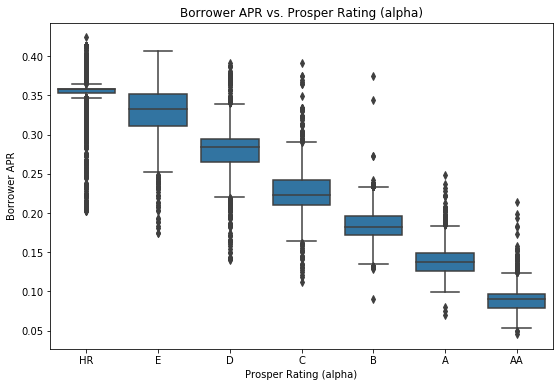

In [28]:
plt.figure(figsize=[9,6])
default_color = sb.color_palette()[0]
sb.boxplot(data=loan_sub, x='prosperrating (alpha)', y='borrowerapr', color=default_color)
plt.xlabel('Prosper Rating (alpha)')
plt.ylabel('Borrower APR')
plt.title('Borrower APR vs. Prosper Rating (alpha)');

The borrower APR decreases with the increasingly better prosper rating. Borrowers with the best Prosper ratings have the lowest borrower APR. It means that the Prosper rating has a strong effect on borrower APR.

## Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

The borrower APR is negatively associated with the loan original amount, which means the more the loan amount, the lower the APR. It also shows that at different size of the loan amount, the APR has a large range, but the range of APR decrease with the increase of loan amount. The Prosper rating also has a strong effect on the borrower APR, which decreases with the better rating.

The borrower APR is negatively associated with the prosper rating (alpha), which means the borrowers with the better Prosper ratings have the lower borrower APR. So the Prosper rating (alpha) has a strong effect on borrower APR.


## Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

The loan original amount is positively correlated with the stated monthly income, it makes sense since borrowers with more monthly income could loan more money. It also shows that borrowers with better rating also have larger monthly income and loan amount. There is a interaction between prosper rating and term. Proportionally, there are more 60 month loans on B and C ratings. There is only 36 months loans for HR rating borrowers.

## Multivariate Exploration

The main thing I want to explore in this part of the analysis is how  the three categorical variables play into the relationship between borrower APR and Loan Amount.

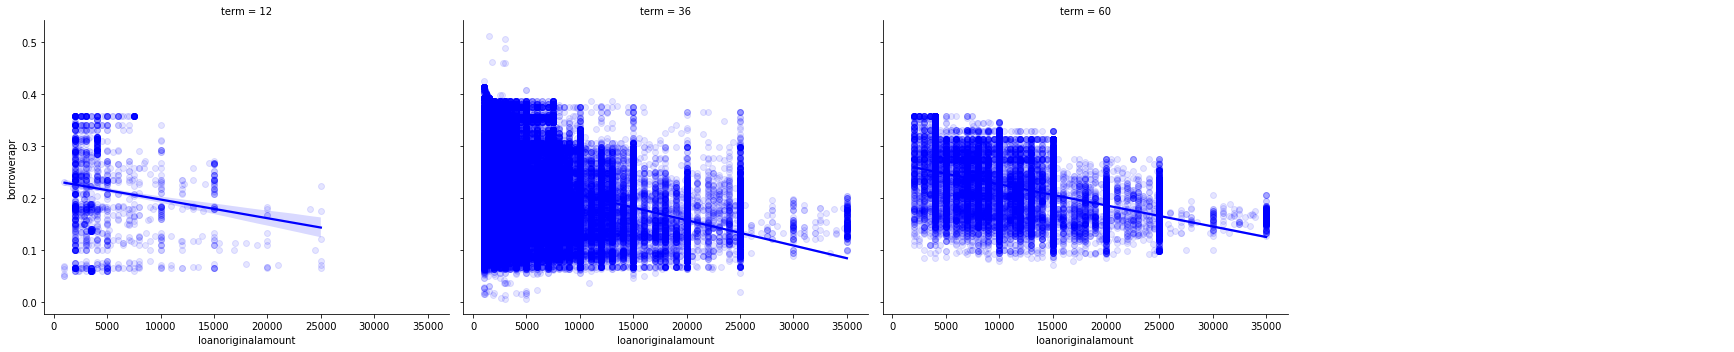

In [29]:
# create faceted heat maps on term variable
g=sb.FacetGrid(data=loan_sub, aspect=1.2, height=5, col='term', col_wrap=4)
g.map(sb.regplot, 'loanoriginalamount', 'borrowerapr', x_jitter=0.02, scatter_kws={'alpha':0.1}, color = 'blue')
g.add_legend();


Term doesn't seem to have effect on relationship of APR and loan amount.

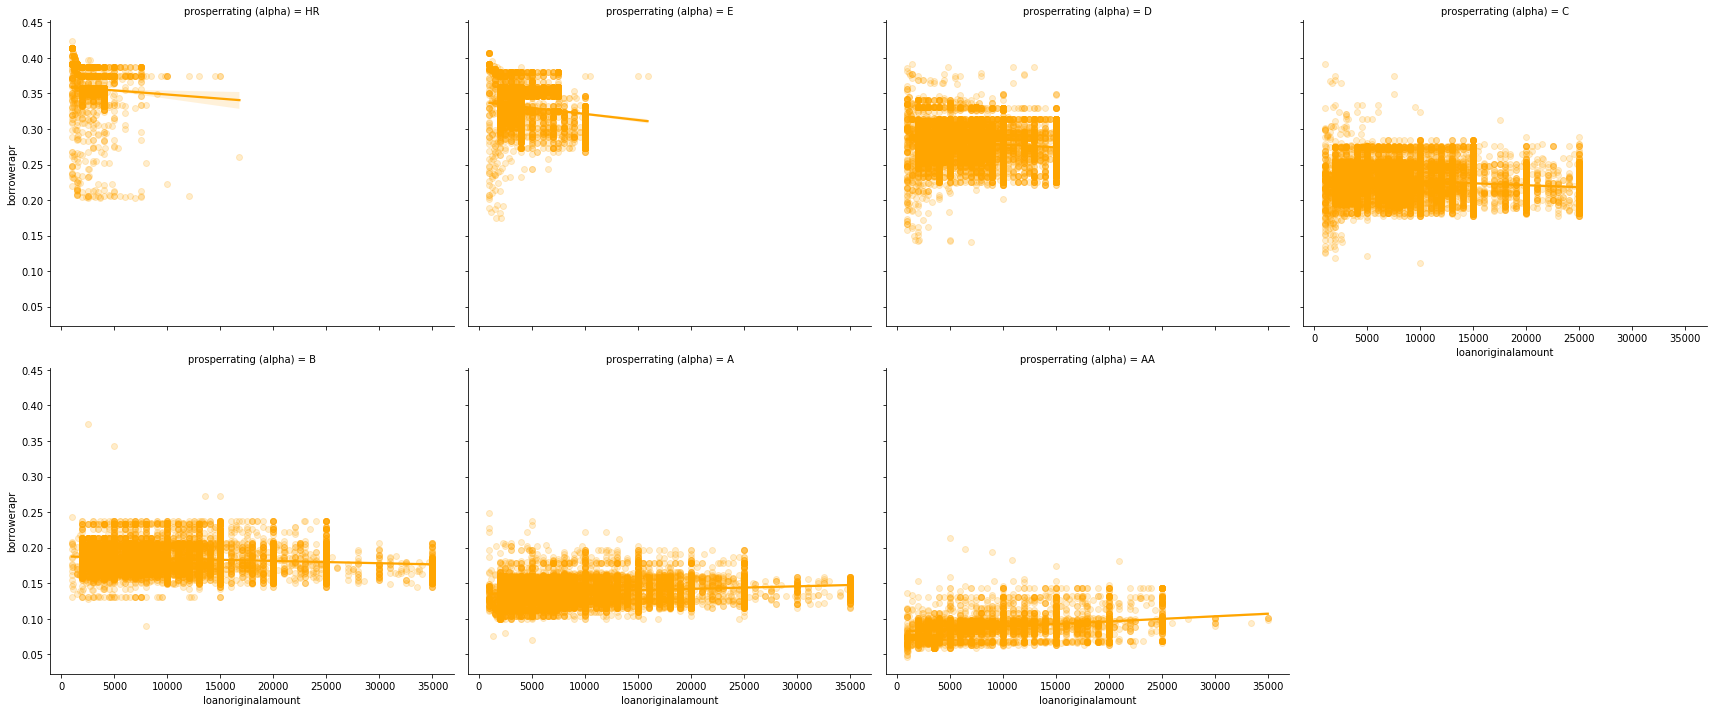

In [30]:
# create faceted heat maps on prosper rating (alpha) variable
g=sb.FacetGrid(data=loan_sub, aspect=1.2, height=5, col='prosperrating (alpha)', col_wrap=4)
g.map(sb.regplot, 'loanoriginalamount', 'borrowerapr', x_jitter=0.02, scatter_kws={'alpha':0.2}, color='orange')
g.add_legend();

Prosper rating (alpha), which are HR-B has the negative correlation with loan original amount and borrower APR, it means borrowers who have the better prosper rating will have the lower borrower APR. However, we see that at the rating of A and AA, the borrower APR is a little big more with larger loan original amount. This may because people with A or AA ratings tend to borrow more money, increasting APR could prevent them borrow even more and maximize the profit. But people with lower ratings tend to borrow less money, decreasing APR could encourage them to borrow more. 

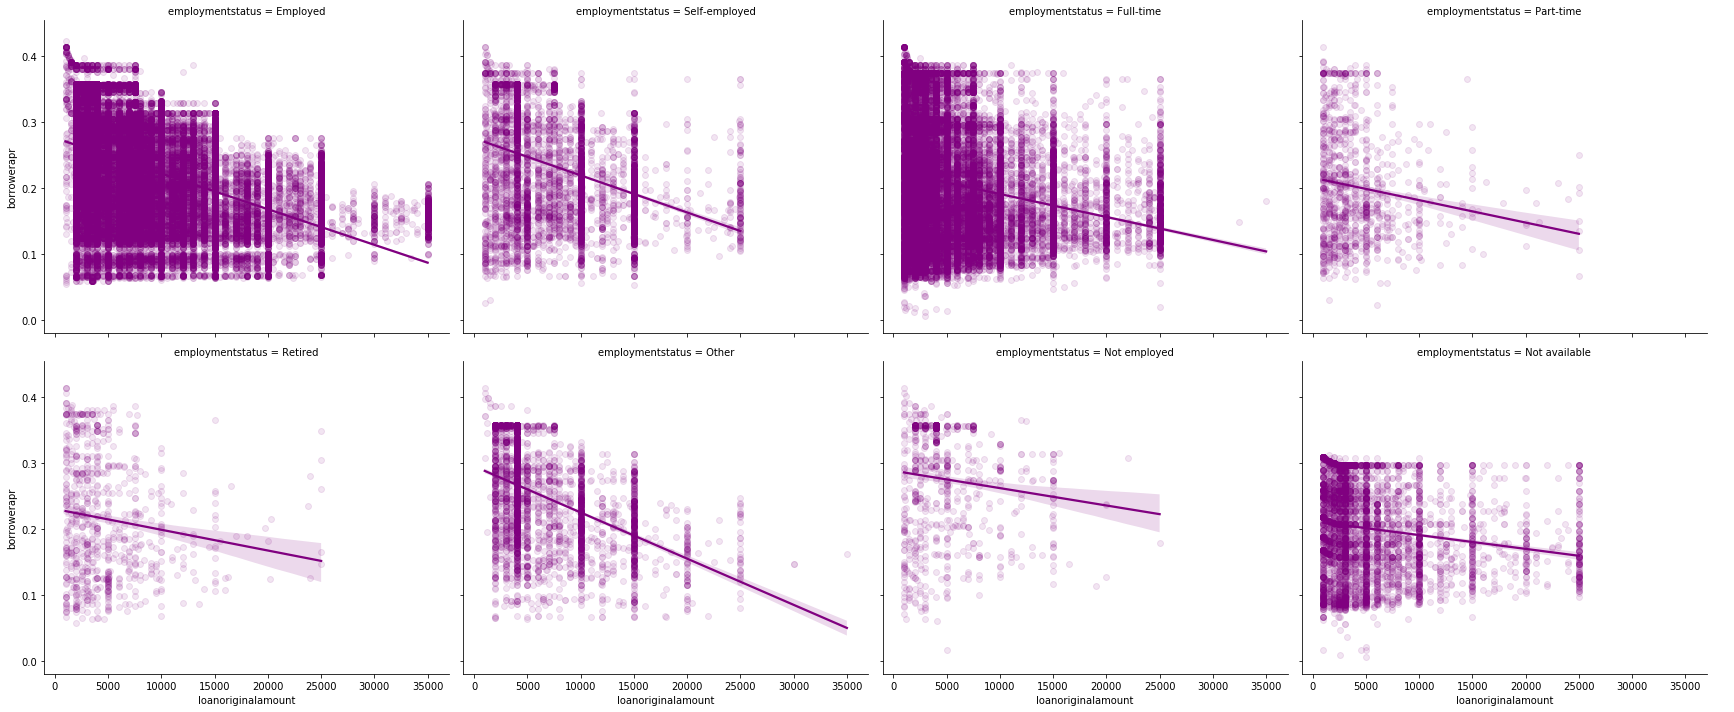

In [31]:
# create faceted heat maps on employment status variable
g=sb.FacetGrid(data=loan_sub, aspect=1.2, height=5, col='employmentstatus', col_wrap=4)
g.map(sb.regplot, 'loanoriginalamount', 'borrowerapr', x_jitter=0.02, scatter_kws={'alpha':0.1}, color='purple')
g.add_legend();

We can see that borrowers are almost employed and full-time and if they borrow with the more loan original amount, the borrower APR will be decreased.

## Borrower APR by Prosper Rating and Term

Text(0.5, 1.0, 'Borrower APR by Prosper Rating and Term')

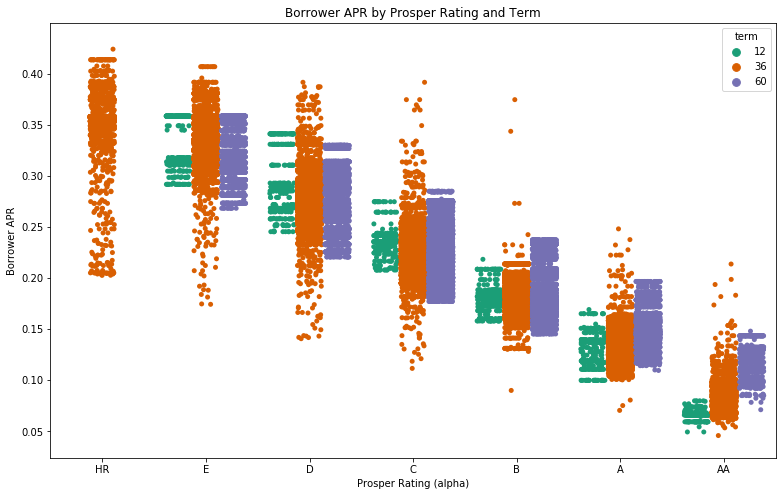

In [32]:
plt.figure(figsize=[13,8])
sb.stripplot(data = loan_sub, x = 'prosperrating (alpha)', y = 'borrowerapr', hue = 'term',
jitter = 0.35, dodge = True, palette = "Dark2")
plt.xlabel('Prosper Rating (alpha)')
plt.ylabel('Borrower APR')
plt.title('Borrower APR by Prosper Rating and Term')

The borrower APR decrease with the increase of borrow term for people with prosper rating from HR - C. But for people with B - AA prosper ratings, the borrower APR increase with the increase of borrow term.

## Loan Original Amount by Prosper Rating and Term

Text(0.5, 1.0, 'Loan Original Amount by Prosper Rating and Term')

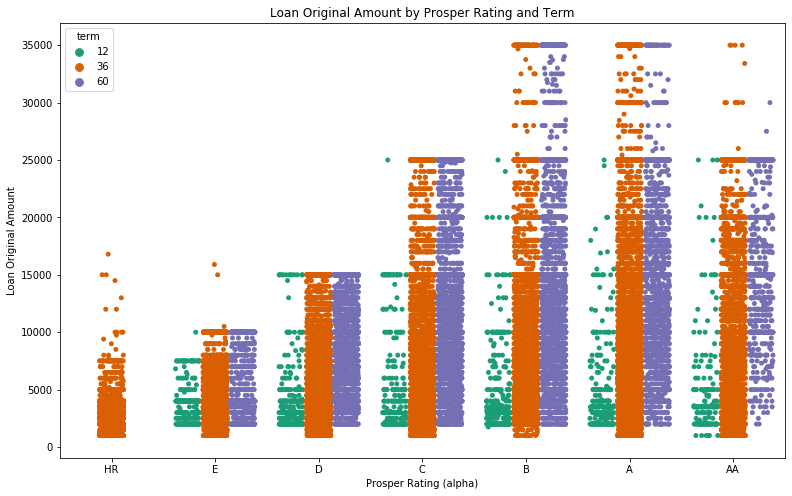

In [33]:
plt.figure(figsize=[13,8])
sb.stripplot(data = loan_sub, x = 'prosperrating (alpha)', y = 'loanoriginalamount', hue = 'term',
jitter = 0.35, dodge = True, palette = "Dark2")
plt.xlabel('Prosper Rating (alpha)')
plt.ylabel('Loan Original Amount')
plt.title('Loan Original Amount by Prosper Rating and Term')

Borrowers are almost A-B prosper rating (alpha) with borrow term of 36 and 60 months, and if they have the better prosper rating, they'll be borrowed more.

## Income Range Effect on relationship between Borrower APR and Term

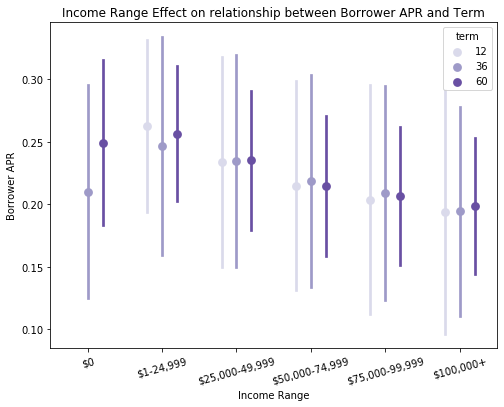

In [34]:
fig = plt.figure(figsize = [8,6])
ax = sb.pointplot(data = loan_sub, x = 'incomerange', y = 'borrowerapr', hue = 'term',
           palette = 'Purples', linestyles = '', dodge = 0.4, ci='sd')
plt.title('Income Range Effect on relationship between Borrower APR and Term')
plt.xlabel('Income Range')
plt.ylabel('Borrower APR')
ax.set_yticklabels([],minor = True)
plt.xticks(rotation = 15);

Overall, we see that the larger income range, the smaller borrower APR with the same term.

## Prosper Rating Effect on Relationship between APR and Loan Amount

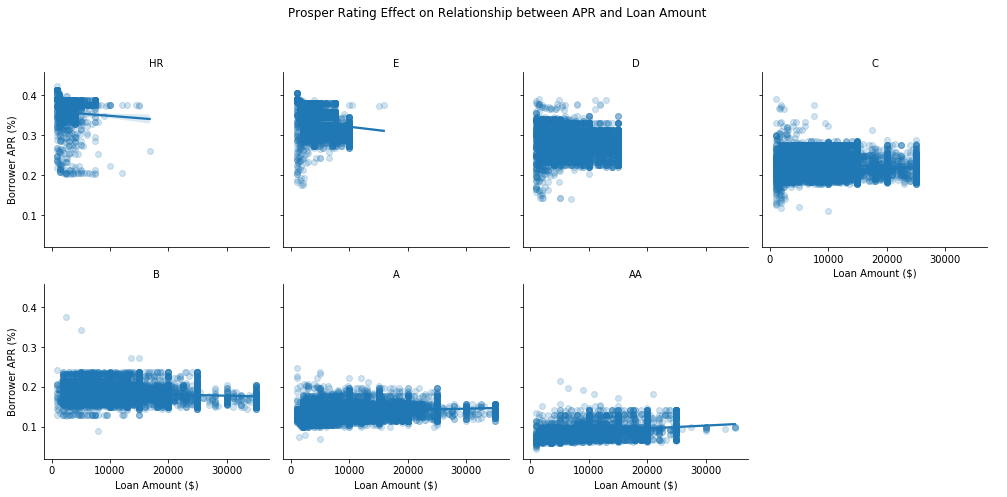

In [35]:
g=sb.FacetGrid(data=loan_sub,col='prosperrating (alpha)', height=3.5, col_wrap=4)
g.map(sb.regplot, 'loanoriginalamount', 'borrowerapr', x_jitter=0.2, scatter_kws={'alpha':0.2});
g.set_titles('{col_name}')
g.add_legend();
g.set_xlabels('Loan Amount ($)')
g.set_ylabels('Borrower APR (%)')
plt.suptitle('Prosper Rating Effect on Relationship between APR and Loan Amount');
plt.subplots_adjust(top=0.85)

The loan amount increases with better rating. The borrower APR decreases with better rating. Interestingly, the relationship between borrower APR and loan amount turns from negative to slightly positive when the Prosper ratings are increased from HR to A or better. This is may because people with A or AA ratings tend to borrow more money, increasting APR could prevent them borrow even more and maximize the profit. But people with lower ratings tend to borrow less money, decreasing APR could encourage them to borrow more.

## Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

In the exploration, I found that the borrower APR is:

	+ negatively correlated with original loan amount: At different size of the loan amount, the APR has a large range, but the range of APR decrease with the increase of loan amount.    
	+ negatively correlated with prosper rating (alpha): The borrower APR also decreases with the increasingly better prosper rating. Borrowers with the best Prosper ratings have the lowest APR. It means that the Prosper rating has a strong effect on borrower APR. Interestingly, the relationship between borrower APR and loan amount turns from negative to slightly positive when the Prosper ratings are increased from HR to A or better. This is may because people with A or AA ratings tend to borrow more money, increasting APR could prevent them borrow even more and maximize the profit. But people with lower ratings tend to borrow less money, decreasing APR could encourage them to borrow more.
    + negatively correlated with borrow term: the borrower APR decrease with the increase of borrow term for people with HR-C raings. But for people with B-AA ratings, the APR increase with the increase of borrow term.

	
## Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

We can see that borrowers are almost employed and full-time and if they borrow with the more loan original amount, the borrower APR will be decreased. Term doesn't seem to have effect on relationship of APR and loan amount. Borrowers with better rating also have larger stated monthly income and loan original amount. Employed, self-employed and full time borrowers have more stated monthly income and loan original amount than part-time, retired and not employed borrowers.
